## The challenge:
Your objective is to predict the hourly demand for taxis in the Bronx area and determine the optimal number of taxis required to meet this demand. The task is divided into five parts, each progressively challenging to showcase your skills in data science, machine learning, and operational optimization.

#### 1.Baseline Model:

Build a simple baseline model to predict hourly demand. Explain your choice of the baseline model and the performance metrics you use to evaluate it.

#### 2.Improved Model:

Develop an improved model by incorporating additional features, refining your data preprocessing steps, or using more sophisticated algorithms. Compare its performance with the baseline model and explain the improvements. Discuss any feature engineering techniques or data transformation methods you employed.
#### 3.Best Model:

Optimize your improved model to achieve the best possible performance. Explain the steps taken to enhance the model and the final results. Provide a clear comparison between the baseline, improved, and best models, highlighting the key improvements.

#### 4.Forecasting the First Week of September 2024:

Using your best model, forecast the hourly demand for taxis in the Bronx for the first week of September 2024. Explain any additional steps or assumptions you took into consideration for this forecasting task, such as seasonal trends, external factors, or potential anomalies.

#### 5.Optimal Number of Taxis:

Determine the optimal number of taxis required to meet the predicted hourly demand in the Bronx. Make reasonable assumptions about factors such as average trip duration, taxi availability, and operational constraints. You might need to consider potential costs and benefits in your analysis. Explain your assumptions and the methodology used to calculate the optimal number of taxis. Discuss the implications of your findings on operational efficiency and customer satisfaction.


In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [132]:
#Read the data
taxi_data=pd.read_csv("TaxiTrips_BronxOrigin2023.csv")

In [133]:
taxi_data.columns,taxi_data.dtypes

(Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
        'trip_distance', 'PULocationID', 'DOLocationID'],
       dtype='object'),
 tpep_pickup_datetime      object
 tpep_dropoff_datetime     object
 passenger_count          float64
 trip_distance            float64
 PULocationID               int64
 DOLocationID               int64
 dtype: object)

In [134]:
weather_data=pd.read_csv(r"Bronx_Weather_Data2023.csv")

In [135]:
weather_data.columns,weather_data.dtypes

(Index(['Unnamed: 0', 'date', 'temperature_2m', 'precipitation', 'rain',
        'snowfall'],
       dtype='object'),
 Unnamed: 0          int64
 date               object
 temperature_2m    float64
 precipitation     float64
 rain              float64
 snowfall          float64
 dtype: object)

In [136]:
location_data=pd.read_csv(r"taxi_zone_lookup.csv")

In [137]:
location_data.columns,location_data.dtypes

(Index(['LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object'),
 LocationID       int64
 Borough         object
 Zone            object
 service_zone    object
 dtype: object)

In [138]:
location_data['Borough'].unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown', nan], dtype=object)

In [139]:
location_data=location_data[location_data['Borough']=="Bronx"]

In [140]:
location_data.LocationID.unique()

array([  3,  18,  20,  31,  32,  46,  47,  51,  58,  59,  60,  69,  78,
        81,  94, 119, 126, 136, 147, 159, 167, 168, 169, 174, 182, 183,
       184, 185, 199, 200, 208, 212, 213, 220, 235, 240, 241, 242, 247,
       248, 250, 254, 259], dtype=int64)

## Data Cleaning and Processing

<!-- tpep_pickup_datetime: The date and time when the meter was engaged.
tpep_dropoff_datetime: The date and time when the meter was disengaged.
passenger_count: The number of passengers in the vehicle. This is a driver-entered value.
trip_distance: The elapsed trip distance in miles reported by the taximeter.
PULocationID: TLC Taxi Zone in which the taximeter was engaged.
DOLocationID: TLC Taxi Zone in which the taximeter was disengaged. -->

In [141]:
# tpep_pickup_datetime: The date and time when the meter was engaged.
# tpep_dropoff_datetime: The date and time when the meter was disengaged.
# passenger_count: The number of passengers in the vehicle. This is a driver-entered value.
# trip_distance: The elapsed trip distance in miles reported by the taximeter.
# PULocationID: TLC Taxi Zone in which the taximeter was engaged.
# DOLocationID: TLC Taxi Zone in which the taximeter was disengaged.

In [142]:
print(taxi_data['tpep_pickup_datetime'].max())
print(taxi_data['tpep_dropoff_datetime'].max())
print(taxi_data['tpep_pickup_datetime'].min())
print(taxi_data['tpep_dropoff_datetime'].min())


2023-12-31 9:59
2024-01-01 0:16
2023-01-01 0:00
2023-01-01 0:16


In [143]:
#Convert the pickup and drop off cols to datetime 

taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])
weather_data['date'] = pd.to_datetime(weather_data['date'])



In [144]:
#Convert the UTC Timezone to avoid merge problems
weather_data['date'] = weather_data['date'].dt.tz_convert(None)


In [145]:
taxi_data['tpep_pickup_datetime'].unique(),weather_data['date'].unique()

(<DatetimeArray>
 ['2023-01-01 00:08:00', '2023-01-01 00:27:00', '2023-01-01 00:16:00',
  '2023-01-01 00:00:00', '2023-01-01 01:51:00', '2023-01-01 01:44:00',
  '2023-01-01 01:59:00', '2023-01-01 02:56:00', '2023-01-01 02:18:00',
  '2023-01-01 02:09:00',
  ...
  '2023-12-31 23:08:00', '2023-12-31 23:19:00', '2023-12-31 23:56:00',
  '2023-12-31 23:11:00', '2023-12-31 23:07:00', '2023-12-31 23:10:00',
  '2023-12-31 23:16:00', '2023-12-31 23:33:00', '2023-12-31 23:38:00',
  '2023-12-31 23:04:00']
 Length: 59199, dtype: datetime64[ns],
 <DatetimeArray>
 ['2023-01-01 00:00:00', '2023-01-01 01:00:00', '2023-01-01 02:00:00',
  '2023-01-01 03:00:00', '2023-01-01 04:00:00', '2023-01-01 05:00:00',
  '2023-01-01 06:00:00', '2023-01-01 07:00:00', '2023-01-01 08:00:00',
  '2023-01-01 09:00:00',
  ...
  '2023-12-31 14:00:00', '2023-12-31 15:00:00', '2023-12-31 16:00:00',
  '2023-12-31 17:00:00', '2023-12-31 18:00:00', '2023-12-31 19:00:00',
  '2023-12-31 20:00:00', '2023-12-31 21:00:00', '2023-12-31

In [146]:

taxi_data= taxi_data.sort_values(by=['tpep_pickup_datetime']).reset_index()

In [147]:
#Filter only for Bronx area
bronx_location_ids=location_data.LocationID.unique()

In [148]:
#Aggregate by hourfor 
bronx_location_ids

array([  3,  18,  20,  31,  32,  46,  47,  51,  58,  59,  60,  69,  78,
        81,  94, 119, 126, 136, 147, 159, 167, 168, 169, 174, 182, 183,
       184, 185, 199, 200, 208, 212, 213, 220, 235, 240, 241, 242, 247,
       248, 250, 254, 259], dtype=int64)

In [149]:
#Check for Location which is for Bronx area
bronx_data = taxi_data[taxi_data['PULocationID'].isin(bronx_location_ids)]


In [150]:
bronx_data.shape

(66000, 7)

In [151]:
bronx_data.columns

Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID'],
      dtype='object')

## Aggregate demand by hour


In [152]:
bronx_data['hour'] = bronx_data['tpep_pickup_datetime'].dt.hour
# bronx_data['date'] = bronx_data['tpep_pickup_datetime'].dt.date

hourly_demand=bronx_data.copy()
# hourly_demand = bronx_data.groupby([bronx_data['tpep_pickup_datetime'].dt.floor('H')]).size().reset_index(name='demand')
hourly_demand['hourly_demand'] = hourly_demand.groupby(hourly_demand['tpep_pickup_datetime'].dt.floor('H'))['tpep_pickup_datetime'].transform('size')

# bronx_data = bronx_data.merge(hourly_demand, left_on='hour', right_on='tpep_pickup_datetime', how='left')


In [153]:
hourly_demand.head()


,index,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,hour,hourly_demand
0,3,2023-01-01 00:00:00,2023-01-01 00:26:00,1.0,0.00,136,233,0,8
1,0,2023-01-01 00:08:00,2023-01-01 00:41:00,1.0,25.84,60,265,0,8
2,2,2023-01-01 00:16:00,2023-01-01 00:16:00,4.0,0.00,174,174,0,8
3,1,2023-01-01 00:27:00,2023-01-01 00:32:00,1.0,1.03,159,168,0,8
4,3934,2023-01-01 00:34:00,2023-01-01 00:55:00,NaN,4.05,247,151,0,8


In [154]:
hourly_demand.columns

Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'hour', 'hourly_demand'],
      dtype='object')

In [155]:
weather_data.columns,bronx_data.columns

(Index(['Unnamed: 0', 'date', 'temperature_2m', 'precipitation', 'rain',
        'snowfall'],
       dtype='object'),
 Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
        'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
        'hour'],
       dtype='object'))

In [156]:
#Merge the dfs- hourly demand and weather data
hourly_demand=pd.merge(hourly_demand,weather_data,left_on="tpep_pickup_datetime",right_on="date",how="left")

In [157]:
# Fill any missing values in weather data (e.g., forward fill)
hourly_demand.fillna(method='ffill', inplace=True)


In [158]:
# hourly_demand[hourly_demand['tpep_pickup_datetime'].between("2023-09-01 23:00:00 ","2023-09-07 00:00:00")].to_csv("Merged_sept_raw.csv",index=False)
# hourly_demand.to_csv("MergedwithWeather.csv",index=False)

In [159]:
#Drop any unwanted cols
hourly_demand.drop(columns=["Unnamed: 0"],inplace=True)


### Feature Engineering

In [160]:
#Add in new features to the data
hourly_demand['day_of_week'] = hourly_demand['tpep_pickup_datetime'].dt.dayofweek
hourly_demand['month']=hourly_demand['tpep_pickup_datetime'].dt.month
# hourly_demand['hour'] = hourly_demand['tpep_pickup_datetime'].dt.hour
hourly_demand['is_weekend']= hourly_demand['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [161]:
hourly_demand['day_of_week'].unique()

array([6, 0, 1, 2, 3, 4, 5])

In [162]:
hourly_demand.columns

Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'hour', 'hourly_demand', 'date', 'temperature_2m', 'precipitation',
       'rain', 'snowfall', 'day_of_week', 'month', 'is_weekend'],
      dtype='object')

In [163]:
# Lag feature for demand
hourly_demand['lag_demand_1'] = hourly_demand['hourly_demand'].shift(1)  # Demand 1 hour ago
hourly_demand['lag_demand_3'] = hourly_demand['hourly_demand'].shift(3)  # Demand 3 hours ago
hourly_demand['lag_demand_6'] = hourly_demand['hourly_demand'].shift(6)  # Demand 6 hours ago


In [164]:
# Drop any rows with NaN values (caused by lagging)
hourly_demand.dropna(inplace=True)

               hourly_demand  lag1_demand  lag2_demand  temperature  \
hourly_demand       1.000000     0.974336     0.949776    -0.074415   
lag1_demand         0.974336     1.000000     0.974336    -0.074839   
lag2_demand         0.949776     0.974336     1.000000    -0.075268   
temperature        -0.074415    -0.074839    -0.075268     1.000000   
precipitation       0.079649     0.080265     0.080873     0.026679   
rain                0.080483     0.081117     0.081744     0.030836   

               precipitation      rain  
hourly_demand       0.079649  0.080483  
lag1_demand         0.080265  0.081117  
lag2_demand         0.080873  0.081744  
temperature         0.026679  0.030836  
precipitation       1.000000  0.998704  
rain                0.998704  1.000000  


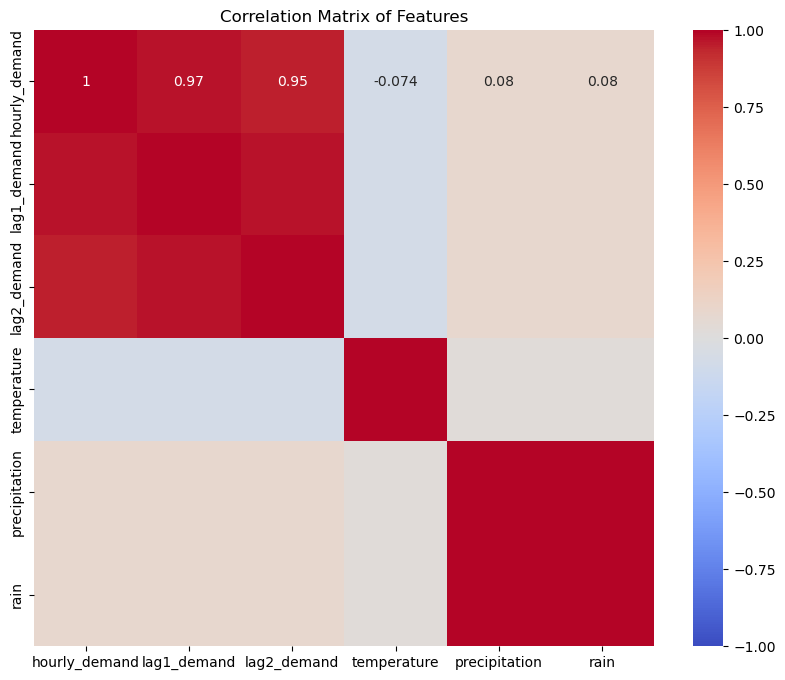

In [165]:
import seaborn as sns


data = pd.DataFrame({
    'hourly_demand': hourly_demand['hourly_demand'],
    'lag1_demand': hourly_demand['hourly_demand'].shift(1),
    'lag2_demand': hourly_demand['hourly_demand'].shift(2),
    'temperature': hourly_demand['temperature_2m'],  
    'precipitation': hourly_demand['precipitation'],
    'rain': hourly_demand['rain']
})

# Drop any rows with NaN values introduced by lagging
data = data.dropna()

# Step 1: Compute the correlation matrix
correlation_matrix = data.corr()

# Step 2: Display the correlation matrix
print(correlation_matrix)

# Step 3: Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()


In [166]:
# Split the data into features and target
X = hourly_demand[['hour', 'day_of_week', 'temperature_2m', 'precipitation', 'rain', 'snowfall', 'lag_demand_1', 'lag_demand_3', 'lag_demand_6']]
y = hourly_demand['hourly_demand']

### Baseline Model

We will use basic time series model like Simple Moving Average for predicting hourly demand 

In [167]:
#Split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [168]:
X_train_temp=hourly_demand[hourly_demand['date'].dt.month==9]

In [169]:
X_train_temp.to_csv("Training_data.csv",index=False)

The Simple Moving Average model predicts demand based on the average of the previous N hours.

In [170]:
window_size=3
# train['moving_avg_pred'] = train['hourly_demand'].rolling(window=window_size).mean().shift(1)
# test['moving_avg_pred'] = test['hourly_demand'].rolling(window=window_size).mean().shift(1)
y_pred_sma = y_train.rolling(window=3).mean().shift(1).fillna(method='bfill')
forecast_sma=hourly_demand.copy()
forecast_sma['SMA_Prediction']=round(y_pred_sma)


In [171]:
forecast_sma.columns

Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'hour', 'hourly_demand', 'date', 'temperature_2m', 'precipitation',
       'rain', 'snowfall', 'day_of_week', 'month', 'is_weekend',
       'lag_demand_1', 'lag_demand_3', 'lag_demand_6', 'SMA_Prediction'],
      dtype='object')

In [172]:
forecast_sma=forecast_sma[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'hour','hourly_demand', 'SMA_Prediction']]

In [173]:
# forecast_sma.to_csv("Baseline_Prediction.csv",index=False)

### Performance metric

In [174]:
#Mean Absolute Error and Mean Squared error for Baseline models
baseline_mae = mean_absolute_error(y_train, y_pred_sma)
baseline_mse = mean_squared_error(y_train, y_pred_sma)
baseline_r2 = r2_score(y_train, y_pred_sma)
baseline_rmse= np.sqrt(mean_squared_error(y_train, y_pred_sma))


print("Baseline Model - SMA")
print(f"MAE: {baseline_mae}, MSE: {baseline_mse}, R-squared: {baseline_r2}, RMSE: {baseline_rmse}" )

Baseline Model - SMA
MAE: 0.8076774947122518, MSE: 3.957155033620608, R-squared: 0.9246313996088382, RMSE: 1.9892599210813573


#### I chose MAE,MSE and R2 for the following reasons:
       MAE 's Robustness to Outliers and Interpretability,
       
       MSE's mathematical Properties and Sensitivity to Outliers,
       
       R2 explains the variance
   

In [175]:
# test.to_csv("Baseline_Model_Pred.csv",index=False)

#### Simple Moving Average is chosen as the Baseline Model because its good for predicting short term forecasts and can be easily customized based on the window size where a larger window will smooth the data more but may lag behind sudden changes, while a smaller window will be more responsive to recent changes in the time series.Its also best for reducing noise from the data.

### Improved Model

In [176]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"Improved Linear Regression Model - MAE: {mae}")
print(f"Improved Linear Regression Model - MSE: {mse}")
print(f"Improved Linear Regression Model - R-squared: {r2}")
print(f"Improved Linear Regression Model - RMSE: {rmse}")


Improved Linear Regression Model - MAE: 0.6124956522215356
Improved Linear Regression Model - MSE: 3.29071945124576
Improved Linear Regression Model - R-squared: 0.9429502621677748
Improved Linear Regression Model - RMSE: 1.814034027036362


In [177]:
forecast_lr = X_test.reset_index()


In [178]:
X_test.columns

Index(['hour', 'day_of_week', 'temperature_2m', 'precipitation', 'rain',
       'snowfall', 'lag_demand_1', 'lag_demand_3', 'lag_demand_6'],
      dtype='object')

In [179]:
forecast_lr=X_test[['hour', 'day_of_week', 'temperature_2m', 'precipitation',
       'rain', 'snowfall']].copy()

In [180]:
forecast_lr['Predicted_demand_LR']=y_pred

In [181]:
forecast_lr['Predicted_demand_LR']=round(forecast_lr['Predicted_demand_LR'])

In [182]:
# forecast_lr.to_csv("Improved_model_pred_LR.csv",index=False)

### Best Model

In [183]:
# Ridge Regression (L2 regularization) - Hyperparameter Tuning using GridSearchCV
ridge = Ridge()
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

best_ridge = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Evaluate Ridge Regression model performance
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge=np.sqrt(mean_squared_error(y_test, y_pred_ridge))


print(f"Ridge Regression Model - MAE: {mae_ridge}")
print(f"Ridge Regression Model - MSE: {mse_ridge}")
print(f"Ridge Regression Model - R-squared: {r2_ridge}")
print(f"Ridge Regression Model - RMSE: {rmse_ridge}")



Ridge Regression Model - MAE: 0.6126531759564379
Ridge Regression Model - MSE: 3.2908009464255925
Ridge Regression Model - R-squared: 0.9429488493221302
Ridge Regression Model - RMSE: 1.8140564893149256


In [184]:
# Lasso Regression (L1 regularization) - Hyperparameter Tuning using GridSearchCV
lasso = Lasso()
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1]}
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

best_lasso = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate Lasso Regression model performance
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso=np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"Lasso Regression Model - MAE: {mae_lasso}")
print(f"Lasso Regression Model - MSE: {mse_lasso}")
print(f"Lasso Regression Model - R-squared: {r2_lasso}")
print(f"Lasso Regression Model - RMSE: {rmse_lasso}")


Lasso Regression Model - MAE: 0.6087325872024463
Lasso Regression Model - MSE: 3.289364538028328
Lasso Regression Model - R-squared: 0.9429737516949086
Lasso Regression Model - RMSE: 1.8136605354994986


In [185]:
# data = hourly_demand['hourly_demand'].values
# data = data.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# def create_sequences(data, time_step=24):
#     X, y = [], []
#     for i in range(len(data) - time_step):
#         X.append(data[i:i + time_step, 0])
#         y.append(data[i + time_step, 0])
#     return np.array(X), np.array(y)

# time_step = 24
# X, y = create_sequences(scaled_data, time_step)

# # Reshape X to be [samples, time steps, features] to fit LSTM input
# X = X.reshape(X.shape[0], X.shape[1], 1)

# # Split the data into training and test sets (e.g., 80% training, 20% test)
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

In [186]:
# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(Dropout(0.2))  # To prevent overfitting
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=25))
# model.add(Dense(units=1))  # Output layer

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, batch_size=64, epochs=10)  # Adjust epochs/batch_size as needed


In [187]:
# # Make predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Inverse transform predictions to original scale
# train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
# test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

# # Inverse transform actual y values
# y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
# y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# # Calculate RMSE
# from sklearn.metrics import mean_squared_error
# train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
# test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
# mae_lstm= mean_absolute_error(y_test_original, test_predict)
# mse_lstm = mean_squared_error(y_test_original, test_predict)

# print(f"LSTM Model - MAE: {mae_lstm}")
# print(f"LSTM Model - MSE: {mse_lstm}")

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')


In [191]:

# # Create features (X) and target variable (y)
# X = hourly_demand[['day_of_week', 'month', 'is_weekend']]  # Use more features if relevant
# y = hourly_demand['hourly_demand']

# Store original indices before splitting
original_indices = hourly_demand.index

#Split data into training and test sets (shuffle=False to preserve the time order)
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Split the indices
train_indices, test_indices = train_test_split(
    original_indices, test_size=0.2, shuffle=False
)
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Align predictions with the original timestamps by using the stored 'test_indices'
xgb_predictions_df = pd.DataFrame({
    'tpep_pickup_datetime': hourly_demand.loc[test_indices, 'tpep_pickup_datetime'],
    'xgb_prediction': xgb_predictions
})



In [215]:
# Calculate MAE, MSE, and R-squared
mae_xgb = mean_absolute_error(y_test, xgb_predictions)
mse_xgb = mean_squared_error(y_test, xgb_predictions)
r2_xgb = r2_score(y_test, xgb_predictions)

# Display the performance metrics
print(f"XGBoost Model - MAE: {mae_xgb}")
print(f"XGBoost Model - MSE: {mse_xgb}")
print(f"XGBoost Model - R-squared: {r2_xgb}")


XGBoost Model - MAE: 1.3513001530755153
XGBoost Model - MSE: 11.364287405194576
XGBoost Model - R-squared: 0.802982409554551


In [193]:
print("\nModel Comparison:")
print(f"Baseline MAE: {baseline_mae}, Improved MAE (Linear Regression): {mae}, Best Lasso MAE: {mae_lasso}")
print(f"Baseline MSE: {baseline_mse}, Improved MSE (Linear Regression): {mse}, Best Lasso MSE: {mse_lasso}")
print(f"Baseline R-squared: {baseline_r2}, Improved R-squared (Linear Regression): {r2}, Best Lasso R-squared: {r2_lasso}")



Model Comparison:
Baseline MAE: 0.8076774947122518, Improved MAE (Linear Regression): 0.6124956522215356, Best Lasso MAE: 0.6087325872024463
Baseline MSE: 3.957155033620608, Improved MSE (Linear Regression): 3.29071945124576, Best Lasso MSE: 3.289364538028328
Baseline R-squared: 0.9246313996088382, Improved R-squared (Linear Regression): 0.9429502621677748, Best Lasso R-squared: 0.9429737516949086


#### Best Model: Based on the performance metrics:
    MAE: The model with the lowest MAE is preferred, indicating it has the smallest average error in predictions.
    MSE: Similarly, the model with the lowest MSE is generally considered better since it penalizes larger errors more heavily.
    R-squared: The model with the highest R-squared value is the best in terms of explained variance.

#### Best Model: Lasso Regression has the lowest MAE and MSE, and the highest R-squared value among the models compared.
    Lasso Regression:
    MAE: 0.6087
    MSE: 3.2894
    R-squared: 0.94297
####  The Lasso Regression model is the best choice for predicting hourly taxi demand based on the provided metrics.

## Forecasting the First Week of September 2024:



In [194]:
def create_forecast_dates(start_date, hours):
    return [start_date + timedelta(hours=i) for i in range(hours)]

# Define the start and end dates for the first week of September 2024
start_date = datetime(2024, 9, 1)
forecast_hours = 24 * 7  # 7 days * 24 hours

# Generate a DataFrame with the forecast dates
forecast_dates = create_forecast_dates(start_date, forecast_hours)
forecast_data = pd.DataFrame({'tpep_pickup_datetime': forecast_dates})

In [195]:
forecast_data

,tpep_pickup_datetime
0,2024-09-01 00:00:00
1,2024-09-01 01:00:00
2,2024-09-01 02:00:00
3,2024-09-01 03:00:00
4,2024-09-01 04:00:00
...,...
163,2024-09-07 19:00:00
164,2024-09-07 20:00:00
165,2024-09-07 21:00:00
166,2024-09-07 22:00:00


### Feature Selection

In [196]:
forecast_data['hour'] = forecast_data['tpep_pickup_datetime'].dt.hour
forecast_data['day_of_week'] = forecast_data['tpep_pickup_datetime'].dt.dayofweek

In [197]:
hourly_demand['lag_demand_2']=hourly_demand['hourly_demand'].shift(2)

In [198]:
hourly_demand.columns

Index(['index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'hour', 'hourly_demand', 'date', 'temperature_2m', 'precipitation',
       'rain', 'snowfall', 'day_of_week', 'month', 'is_weekend',
       'lag_demand_1', 'lag_demand_3', 'lag_demand_6', 'lag_demand_2'],
      dtype='object')

In [199]:
hourly_demand['rolling_mean_3'] = hourly_demand['hourly_demand'].rolling(window=3).mean()
hourly_demand = hourly_demand.dropna()


In [200]:
X = hourly_demand[['hour', 'day_of_week', 
       'lag_demand_1', 'lag_demand_3', 'lag_demand_2', "rolling_mean_3"]]
y = hourly_demand['hourly_demand']

In [201]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [202]:
# Train Lasso Regression Model
lasso_model = Lasso(alpha=grid_search_lasso.best_params_['alpha']) 
lasso_model.fit(X_scaled, y)

Lasso(alpha=0.01)

In [203]:
hourly_demand['hourly_demand'].iloc[-3:].values

array([24, 24, 24], dtype=int64)

In [204]:
forecast_data

,tpep_pickup_datetime,hour,day_of_week
0,2024-09-01 00:00:00,0,6
1,2024-09-01 01:00:00,1,6
2,2024-09-01 02:00:00,2,6
3,2024-09-01 03:00:00,3,6
4,2024-09-01 04:00:00,4,6
...,...,...,...
163,2024-09-07 19:00:00,19,5
164,2024-09-07 20:00:00,20,5
165,2024-09-07 21:00:00,21,5
166,2024-09-07 22:00:00,22,5


#### Forecasting Demand using Lasso


In [205]:
latest_demand = hourly_demand['hourly_demand'].iloc[-3:].values  # last three known demand values


In [213]:
X_forecast = hourly_demand[['hour', 'day_of_week', 'temperature_2m', 'precipitation', 'rain', 'snowfall', 'lag_demand_1', 'lag_demand_3', 'lag_demand_6']]

# Predict using the trained XGBoost model
hourly_demand['XGB_demand'] = xgb_model.predict(X_forecast)
hourly_demand['XGB_demand'] = round(hourly_demand['XGB_demand'] )
# Step 3: Format the output
# Combine predicted demand with the date information
final_forecast = hourly_demand[['date', 'hour','day_of_week', 'XGB_demand']]

# Step 4: Display or return the forecast
print(final_forecast.head())

# Optionally save the forecast to a CSV file
final_forecast.to_csv('xgb_forecast_september_week1.csv', index=False)

         date  hour  day_of_week  XGB_demand
8  2023-01-01     1            6         7.0
9  2023-01-01     1            6         4.0
10 2023-01-01     1            6         4.0
11 2023-01-01     1            6         4.0
12 2023-01-01     2            6         4.0


In [987]:
predicted_demand = []

for i in range(forecast_hours):
    forecast_hour = forecast_data.iloc[i]
    
    features = np.array([forecast_hour['hour'], forecast_hour['day_of_week'], latest_demand[0], latest_demand[1], latest_demand[2], np.mean(latest_demand)])
    
    features_scaled = scaler.transform([features])
    
    demand_prediction = lasso_model.predict(features_scaled)[0]
    
    predicted_demand.append(demand_prediction)
    
    latest_demand = np.roll(latest_demand, -1)
    latest_demand[-1] = demand_prediction

forecast_data['predicted_demand'] = predicted_demand


In [988]:
forecast_data['predicted_demand'] = round(forecast_data['predicted_demand'])

In [989]:
forecast_data.to_csv("Forecast_Sept_firstweek.csv",index=False)

In [990]:
hourly_demand['hourly_demand'].describe()

count    65992.000000
mean        13.184295
std          7.356553
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         47.000000
Name: hourly_demand, dtype: float64

## Optimal Number of Taxis

#### Assumptions
    Average Trip Duration: Assume the average trip duration for a taxi ride in the Bronx is 30 minutes (0.5 hours). This means that, on average, a taxi can complete two trips per hour.
    
    Taxi Availability: Assume that a taxi is available and ready to accept a new fare immediately after completing the previous trip.
    
    Demand Prediction: We already have the hourly demand forecast for the first week of September using the Lasso model. Let’s assume this is an accurate prediction of customer demand.
    
    Operational Constraints:
    
    Taxi Shift Length: Taxis operate in 12-hour shifts, so the availability of each taxi is 12 hours a day.
    Safety Buffer: Add a buffer of 10% to account for unpredictable events such as traffic, delays, or downtime.
    Cost Considerations: For this analysis, we'll assume that the costs of increasing the taxi fleet are proportional to the number of taxis deployed. The goal is to meet the demand while minimizing under-utilization (idle taxis).



In [1001]:
predicted_demand = forecast_data['predicted_demand']

# Assumptions
average_trips_per_hour = 2  # Each taxi can complete 2 trips per hour on average
safety_buffer = 1.10  # 10% safety buffer for unexpected demand

# Calculate the number of taxis required each hour
taxis_required = (predicted_demand / average_trips_per_hour) * safety_buffer

forecast_data['taxis_required'] = np.ceil(taxis_required)

max_taxis_needed = forecast_data['taxis_required'].max()

print(forecast_data[['tpep_pickup_datetime', 'predicted_demand', 'taxis_required']])

# Maximum number of taxis needed during the week
print(f"Maximum number of taxis required: {max_taxis_needed}")


    tpep_pickup_datetime  predicted_demand  taxis_required
0    2024-09-01 00:00:00              24.0            14.0
1    2024-09-01 01:00:00              24.0            14.0
2    2024-09-01 02:00:00              23.0            13.0
3    2024-09-01 03:00:00              23.0            13.0
4    2024-09-01 04:00:00              23.0            13.0
..                   ...               ...             ...
163  2024-09-07 19:00:00               3.0             2.0
164  2024-09-07 20:00:00               3.0             2.0
165  2024-09-07 21:00:00               3.0             2.0
166  2024-09-07 22:00:00               3.0             2.0
167  2024-09-07 23:00:00               3.0             2.0

[168 rows x 3 columns]
Maximum number of taxis required: 14.0


In [1003]:
forecast_data['taxis_required'].describe()

count    168.00000
mean       5.37500
std        3.27335
min        2.00000
25%        3.00000
50%        4.00000
75%        8.00000
max       14.00000
Name: taxis_required, dtype: float64

In [1002]:
forecast_data.to_csv("Optimal_taxis.csv",index=False)

### Implications
    Operational Efficiency: Adequate supply of taxis ensures minimal wait times for customers, enhancing service quality.
    Customer Satisfaction: Sufficient availability can improve customer experiences, reducing the likelihood of long waits.
    Cost Considerations: Balancing the number of taxis with operational costs and customer demand is crucial for profitability